In [2]:
# !pip uninstall gym -y


In [3]:
# !pip install gym[atari]
# !pip install autorom[accept-rom-license]

In [4]:
# !pip install autorom[accept-rom-license]

In [5]:
# !pip install gymnasium[atari]

In [6]:
#  

In [7]:
import gymnasium as gym

# Listar todos los ambientes registrados
env_specs = gym.envs.registry.keys()
print("Ambientes disponibles en Gymnasium:")
for env in env_specs:
    print(env)


Ambientes disponibles en Gymnasium:
CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
phys2d/CartPole-v0
phys2d/CartPole-v1
phys2d/Pendulum-v0
LunarLander-v2
LunarLanderContinuous-v2
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v2
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v0
Taxi-v3
tabular/Blackjack-v0
tabular/CliffWalking-v0
Reacher-v2
Reacher-v4
Pusher-v2
Pusher-v4
InvertedPendulum-v2
InvertedPendulum-v4
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
Hopper-v2
Hopper-v3
Hopper-v4
Swimmer-v2
Swimmer-v3
Swimmer-v4
Walker2d-v2
Walker2d-v3
Walker2d-v4
Ant-v2
Ant-v3
Ant-v4
Humanoid-v2
Humanoid-v3
Humanoid-v4
HumanoidStandup-v2
HumanoidStandup-v4
GymV26Environment-v0
GymV21Environment-v0
Adventure-v0
AdventureDeterministic-v0
AdventureNoFrameskip-v0
Adventure-v4
AdventureDeterministic-v4
AdventureNoFrameskip-v4
Adventure-ram-v0
Adventure-ramDeterministic-v0
Adventure-ramNoFrameskip

In [8]:
import gym # or "import gymnasium as gym"
print(gym.make("ALE/Pong-v5"))

<OrderEnforcing<PassiveEnvChecker<AtariEnv<ALE/Pong-v5>>>>


In [9]:
import gymnasium as gym

# Filtrar ambientes que contienen 'SpaceInvaders'
space_invaders_envs = [env for env in gym.envs.registry.keys() if 'SpaceInvaders' in env]
print("\nAmbientes de SpaceInvaders disponibles:")
for env in space_invaders_envs:
    print(env)



Ambientes de SpaceInvaders disponibles:
SpaceInvaders-v0
SpaceInvadersDeterministic-v0
SpaceInvadersNoFrameskip-v0
SpaceInvaders-v4
SpaceInvadersDeterministic-v4
SpaceInvadersNoFrameskip-v4
SpaceInvaders-ram-v0
SpaceInvaders-ramDeterministic-v0
SpaceInvaders-ramNoFrameskip-v0
SpaceInvaders-ram-v4
SpaceInvaders-ramDeterministic-v4
SpaceInvaders-ramNoFrameskip-v4
ALE/SpaceInvaders-v5
ALE/SpaceInvaders-ram-v5


In [10]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display
from PIL import Image
import cv2
import imageio


In [11]:
def preprocess_frame(frame):
    """
    Preprocesa un frame de observación:
    - Convierte a escala de grises.
    - Recorta la imagen para eliminar partes innecesarias.
    - Redimensiona la imagen a 84x84 píxeles.
    - Normaliza los valores de píxeles.
    """
    # Convertir a escala de grises
    frame = np.mean(frame, axis=2).astype(np.uint8)
    
    # Recortar la imagen (ajusta estos valores si es necesario)
    frame = frame[30:-10, :]
    
    # Redimensionar la imagen
    frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
    
    # Normalizar los valores de píxeles
    frame = frame / 255.0
    return frame

def stack_frames(stacked_frames, frame, is_new_episode):
    """
    Apila frames para capturar la dinámica temporal.
    """
    frame = preprocess_frame(frame)
    if is_new_episode:
        # Resetear la pila de frames
        stacked_frames = deque([np.zeros((84,84), dtype=np.float32) for _ in range(4)], maxlen=4)
        for _ in range(4):
            stacked_frames.append(frame)
    else:
        stacked_frames.append(frame)
    stacked_state = np.stack(stacked_frames, axis=0)
    return stacked_state, stacked_frames


In [12]:
class CNN(nn.Module):
    def __init__(self, action_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)  # Input channels = 4 (frames apilados)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(7*7*64, 512)
        self.output = nn.Linear(512, action_size)
        
    def forward(self, state):
        x = torch.relu(self.conv1(state))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        return self.output(x)


In [13]:
class Agent:
    def __init__(self, action_size):
        self.action_size = action_size

        # Hiperparámetros
        self.gamma = 0.99
        self.epsilon = 1.0  # Valor inicial de epsilon
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.999995  # Decaimiento muy lento
        self.learning_rate = 0.00025
        self.batch_size = 32
        self.memory = deque(maxlen=100000)

        # Dispositivo de computación (GPU si está disponible)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Redes neuronales
        self.policy_net = CNN(action_size).to(self.device)
        self.target_net = CNN(action_size).to(self.device)
        self.update_target_network()

        self.criterion = nn.SmoothL1Loss()  # Huber Loss
        self.optimizer = optim.RMSprop(self.policy_net.parameters(), lr=self.learning_rate)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # Añadir dimensión de batch
        with torch.no_grad():
            action_values = self.policy_net(state)
        return np.argmax(action_values.cpu().data.numpy())

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)

        states = np.array([m[0] for m in minibatch], dtype=np.float32)
        actions = np.array([m[1] for m in minibatch], dtype=np.int64)
        rewards = np.array([m[2] for m in minibatch], dtype=np.float32)
        next_states = np.array([m[3] for m in minibatch], dtype=np.float32)
        dones = np.array([m[4] for m in minibatch], dtype=np.uint8)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Obtener Q(s,a) de la red de políticas
        q_values = self.policy_net(states).gather(1, actions).squeeze()

        # Obtener Q(s',a') de la red objetivo
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]

        # Calcular el valor objetivo
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Calcular la pérdida
        loss = self.criterion(q_values, target_q_values)

        # Optimizar la red
        self.optimizer.zero_grad()
        loss.backward()
        # Clipping de gradientes
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        # Reducir epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [14]:
# Crear el ambiente con el nombre correcto
env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array')
action_size = env.action_space.n
agent = Agent(action_size)

episodes = 1000  # Se recomienda más episodios para ambientes complejos
target_update_steps = 1000  # Actualizar la red objetivo cada cierto número de pasos
scores = []
average_scores = []

# Inicializar variables
stacked_frames = deque([np.zeros((84,84), dtype=np.float32) for _ in range(4)], maxlen=4)
step = 0  # Contador de pasos totales

for e in range(1, episodes + 1):
    state, _ = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    total_reward = 0
    terminated = False
    truncated = False
    while not (terminated or truncated):
        # Elegir acción
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
        done = terminated or truncated
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.replay()
        step += 1

        # Actualizar la red objetivo cada cierto número de pasos
        if step % target_update_steps == 0:
            agent.update_target_network()

        if done:
            print(f"Episodio: {e}/{episodes}, Puntuación: {total_reward}, Epsilon: {agent.epsilon:.6f}")
            break
    scores.append(total_reward)
    average_score = np.mean(scores[-100:])  # Promedio de los últimos 100 episodios
    average_scores.append(average_score)
    
    # Generar GIF cada 200 episodios
    if e % 200 == 0:
        # Ejecutar un episodio de evaluación y capturar frames
        frames = []
        eval_env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array')
        state_eval, _ = eval_env.reset()
        stacked_frames_eval = deque([np.zeros((84,84), dtype=np.float32) for _ in range(4)], maxlen=4)
        state_eval, stacked_frames_eval = stack_frames(stacked_frames_eval, state_eval, True)
        terminated_eval = False
        truncated_eval = False
        while not (terminated_eval or truncated_eval):
            frame = eval_env.render()
            frames.append(frame)
            action = np.argmax(agent.policy_net(torch.FloatTensor(state_eval).unsqueeze(0).to(agent.device)).detach().cpu().numpy())
            next_state_eval, _, terminated_eval, truncated_eval, _ = eval_env.step(action)
            next_state_eval, stacked_frames_eval = stack_frames(stacked_frames_eval, next_state_eval, False)
            state_eval = next_state_eval
        eval_env.close()
        print(f'GIF guardado para el episodio {e}')
        
        # Crear y guardar el GIF
        gif_filename = f'spaceinvaders_training_episode_{e}.gif'
        imageio.mimsave(gif_filename, frames, fps=30)
        print(f'GIF guardado como {gif_filename}')
env.close()


Episodio: 1/1000, Puntuación: 55.0, Epsilon: 0.998301
Episodio: 2/1000, Puntuación: 45.0, Epsilon: 0.996068
Episodio: 3/1000, Puntuación: 105.0, Epsilon: 0.993322
Episodio: 4/1000, Puntuación: 75.0, Epsilon: 0.991348
Episodio: 5/1000, Puntuación: 215.0, Epsilon: 0.985871
Episodio: 6/1000, Puntuación: 135.0, Epsilon: 0.983581
Episodio: 7/1000, Puntuación: 120.0, Epsilon: 0.981395
Episodio: 8/1000, Puntuación: 210.0, Epsilon: 0.977517
Episodio: 9/1000, Puntuación: 160.0, Epsilon: 0.974506
Episodio: 10/1000, Puntuación: 135.0, Epsilon: 0.971936
Episodio: 11/1000, Puntuación: 105.0, Epsilon: 0.969805
Episodio: 12/1000, Puntuación: 480.0, Epsilon: 0.966306
Episodio: 13/1000, Puntuación: 155.0, Epsilon: 0.964042
Episodio: 14/1000, Puntuación: 30.0, Epsilon: 0.962621
Episodio: 15/1000, Puntuación: 185.0, Epsilon: 0.959532
Episodio: 16/1000, Puntuación: 180.0, Epsilon: 0.956652
Episodio: 17/1000, Puntuación: 50.0, Epsilon: 0.954903
Episodio: 18/1000, Puntuación: 120.0, Epsilon: 0.952529
Episod

C:\Users\ealda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


GIF guardado para el episodio 200
GIF guardado como spaceinvaders_training_episode_200.gif
Episodio: 201/1000, Puntuación: 310.0, Epsilon: 0.580877
Episodio: 202/1000, Puntuación: 315.0, Epsilon: 0.578321
Episodio: 203/1000, Puntuación: 100.0, Epsilon: 0.577189
Episodio: 204/1000, Puntuación: 610.0, Epsilon: 0.573951
Episodio: 205/1000, Puntuación: 440.0, Epsilon: 0.571000
Episodio: 206/1000, Puntuación: 65.0, Epsilon: 0.569830
Episodio: 207/1000, Puntuación: 155.0, Epsilon: 0.568382
Episodio: 208/1000, Puntuación: 65.0, Epsilon: 0.567136
Episodio: 209/1000, Puntuación: 110.0, Epsilon: 0.565658
Episodio: 210/1000, Puntuación: 65.0, Epsilon: 0.564810
Episodio: 211/1000, Puntuación: 135.0, Epsilon: 0.562943
Episodio: 212/1000, Puntuación: 135.0, Epsilon: 0.561237
Episodio: 213/1000, Puntuación: 145.0, Epsilon: 0.559612
Episodio: 214/1000, Puntuación: 700.0, Epsilon: 0.557509
Episodio: 215/1000, Puntuación: 75.0, Epsilon: 0.556164
Episodio: 216/1000, Puntuación: 415.0, Epsilon: 0.554279
E

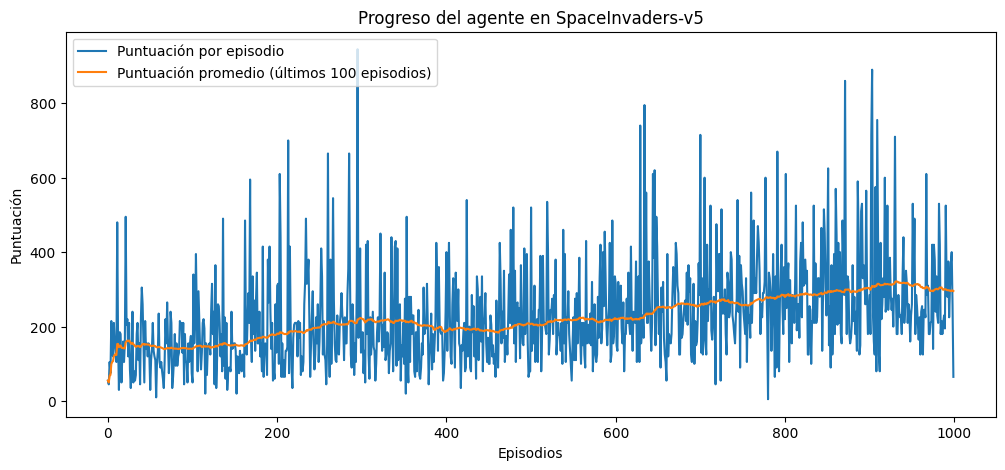

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(scores, label='Puntuación por episodio')
plt.plot(average_scores, label='Puntuación promedio (últimos 100 episodios)')
plt.xlabel('Episodios')
plt.ylabel('Puntuación')
plt.title('Progreso del agente en SpaceInvaders-v5')
plt.legend()
plt.show()


Puntuación total en la evaluación final: 225.0
GIF de la evaluación final guardado como spaceinvaders_evaluation_final.gif


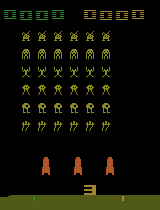

In [16]:
# Reducir epsilon a mínimo para evaluar sin exploración
agent.epsilon = 0.0

# Evaluación final
eval_env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array')
state_eval, _ = eval_env.reset()
stacked_frames_eval = deque([np.zeros((84,84), dtype=np.float32) for _ in range(4)], maxlen=4)
state_eval, stacked_frames_eval = stack_frames(stacked_frames_eval, state_eval, True)
terminated_eval = False
truncated_eval = False
frames = []
total_reward = 0

while not (terminated_eval or truncated_eval):
    frame = eval_env.render()
    frames.append(frame)
    action = np.argmax(agent.policy_net(torch.FloatTensor(state_eval).unsqueeze(0).to(agent.device)).detach().cpu().numpy())
    next_state_eval, reward, terminated_eval, truncated_eval, _ = eval_env.step(action)
    next_state_eval, stacked_frames_eval = stack_frames(stacked_frames_eval, next_state_eval, False)
    state_eval = next_state_eval
    total_reward += reward

eval_env.close()
print(f'Puntuación total en la evaluación final: {total_reward}')

# Crear y guardar el GIF de la evaluación final
gif_filename = 'spaceinvaders_evaluation_final.gif'
imageio.mimsave(gif_filename, frames, fps=30)
print(f'GIF de la evaluación final guardado como {gif_filename}')

# Mostrar el GIF en el notebook
from IPython.display import Image as IPyImage
display(IPyImage(filename=gif_filename))
